# Chargement
## Librairies

In [ ]:
!pip install nonconformist
!pip install sklearn
!pip install numpy==1.18.5
!pip install keras==2.6.0
!pip install tensorflow==2.6.0

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nonconformist.nc import NcFactory
from nonconformist.base import RegressorAdapter
from nonconformist.cp import IcpClassifier, IcpRegressor
from nonconformist.nc import ClassifierNc, MarginErrFunc

# Games of Thrones
## Données
### Chargement

In [3]:
url = 'https://raw.githubusercontent.com/astridgcn/Info/main/got.csv'
got = pd.read_csv(url, sep = ";")

In [4]:
got

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,numDeadRelations,popularity,isAlive
0,1,Arya Stark,0,Northmen,House Stark,1,1,1,1,1,0,1,8,1.0,1
1,2,Barristan Selmy,1,Westeros,House Selmy,1,1,1,1,1,0,1,0,1.0,1
2,3,Bran Stark,1,Northmen,House Stark,1,1,1,1,1,0,1,7,1.0,1
3,4,Cersei Lannister,0,Westerlands,House Lannister,1,1,1,1,1,1,1,9,1.0,1
4,5,Daenerys Targaryen,0,Valyrian,House Targaryen,1,1,1,1,1,1,1,15,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,251,Walder Frey (son of Merrett),1,NaN,House Frey,0,0,0,0,0,0,0,0,0.0,0
1933,250,Walder Frey (son of Ryman),1,Rivermen,House Frey,0,0,0,0,0,0,0,0,0.0,1
1934,261,Wate,0,NaN,House Targaryen,0,0,0,0,0,0,0,0,0.0,1
1935,24,Willum,1,NaN,NaN,1,0,0,0,0,0,1,0,0.0,1


In [5]:
got.dtypes

S.No                  int64
name                 object
male                  int64
culture              object
house                object
book1                 int64
book2                 int64
book3                 int64
book4                 int64
book5                 int64
isMarried             int64
isNoble               int64
numDeadRelations      int64
popularity          float64
isAlive               int64
dtype: object

### Sélection

<AxesSubplot:>

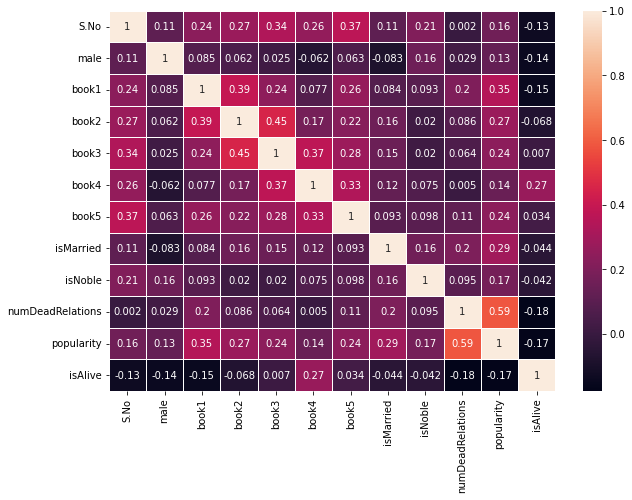

In [6]:
corr = got.corr(method = 'pearson').round(3)
plt.figure(figsize = (10,7))
sns.heatmap(data = corr, annot = True, linewidth = .5)

## Entraînement
### Préparation
#### Variable d'intérêt

In [7]:
X = pd.DataFrame(np.c_[got['male'], got['book1'], got['book4'], got['numDeadRelations'], got['popularity']], 
                 columns = ['male', 'book1', 'book4', 'numDeadRelations', 'popularity'])
y = got['isAlive']

In [8]:
#idx = np.random.permutation(X.size)
#idx

### Division du jeu de données
#### Effectifs

In [9]:
n_train = round(len(got) * 0.6)
n_test = round(len(got) * 0.2)
n_calib = len(got) - (n_train + n_test)
print(n_train, n_test, n_calib)

1162 387 388


#### Division

In [10]:
#idx_train, idx_cal, idx_test = idx[:n_train], idx[n_train:(n_train + n_test)], idx[(n_train + n_test):]
X_train = X[0:n_train]
y_train = y[0:n_train]
X_calib = X[n_train:(n_train + n_test)]
y_calib = y[n_train:(n_train + n_test)]
X_test = X[(n_train + n_test):]
y_test = y[(n_train + n_test):]

### Modèle
#### Création du modèle

In [11]:
#nc = NcFactory.create_nc(KNeighborsRegressor(n_neighbors=11)) # 0.88 accuracy
nc = NcFactory.create_nc(RandomForestRegressor(n_estimators=500)) # 0.92 accuracy
#nc = NcFactory.create_nc(DecisionTreeRegressor(min_samples_leaf=5)) # 0.92 accuracy
icp = IcpRegressor(nc)

#### Entraînement

In [12]:
icp.fit(X_train, y_train)

#### Calibration

In [13]:
icp.calibrate(X_calib, y_calib)

## Prédiction
### Prédiction des valeurs

In [ ]:
y_pred = icp.predict(X_test.values, significance = 0.05)

#### Niveau de précision

In [15]:
suc = 0
for i in range(n_test):
    if (y_test[(n_train + n_test + i)] > y_pred[i,0]) and (y_test[(n_train + n_test + i)] < y_pred[i,1]):
      suc += 1
acc = suc / n_test
("Précision du modèle :", acc)

('Précision du modèle :', 0.9224806201550387)

# Crise cardiaque
## Données
### Chargement

In [16]:
stroke = pd.read_csv('https://raw.githubusercontent.com/astridgcn/conformal-prediction-data/main/healthcare-dataset-stroke-data.csv', sep = ",") 

In [17]:
stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [18]:
stroke['gender'] = pd.factorize(stroke['gender'])[0]
stroke['ever_married'] = pd.factorize(stroke['ever_married'])[0]
stroke['work_type'] = pd.factorize(stroke['work_type'])[0]
stroke['Residence_type'] = pd.factorize(stroke['Residence_type'])[0]
stroke['smoking_status'] = pd.factorize(stroke['smoking_status'])[0]
stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,51676,1,61.0,0,0,0,1,1,202.21,NaN,1,1
2,31112,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,60182,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1665,1,79.0,1,0,0,1,1,174.12,24.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,0,0,0,83.75,NaN,1,0
5106,44873,1,81.0,0,0,0,1,0,125.20,40.0,1,0
5107,19723,1,35.0,0,0,0,1,1,82.99,30.6,1,0
5108,37544,0,51.0,0,0,0,0,1,166.29,25.6,0,0


### Sélection

<AxesSubplot:>

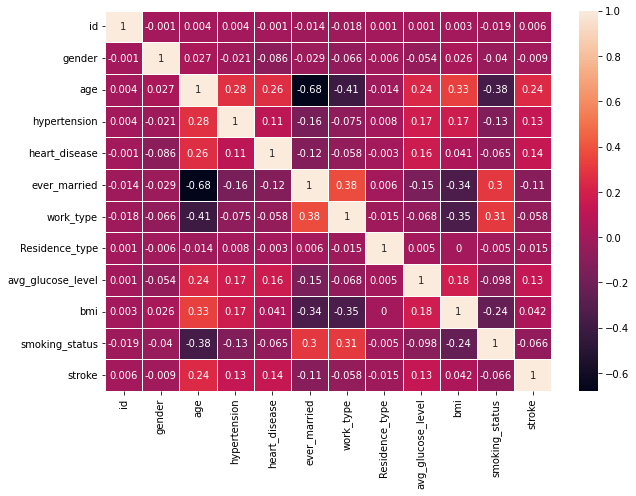

In [19]:
corr = stroke.corr(method = 'pearson').round(3)
plt.figure(figsize = (10,7))
sns.heatmap(data = corr, annot = True, linewidth = .5)

## Entraînement
### Préparation
#### Variable d'intérêt

In [20]:
X = pd.DataFrame(np.c_[stroke['age'], stroke['hypertension'], stroke['heart_disease'], stroke['ever_married'], stroke['work_type'], stroke['avg_glucose_level'], stroke['smoking_status']], 
                 columns = ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'])
y = stroke['stroke']

### Division du jeu de données
#### Effectifs

In [21]:
n_train = round(len(stroke) * 0.6)
n_test = round(len(stroke) * 0.2)
n_calib = len(stroke) - (n_train + n_test)
print(n_train, n_test, n_calib)

3066 1022 1022


#### Division

In [22]:
X_train = X[0:n_train]
y_train = y[0:n_train]
X_calib = X[n_train:(n_train + n_test)]
y_calib = y[n_train:(n_train + n_test)]
X_test = X[(n_train + n_test):]
y_test = y[(n_train + n_test):]

### Modèle
#### Création du modèle

In [23]:
#nc = NcFactory.create_nc(KNeighborsRegressor(n_neighbors=11)) # accuracy 0.93
nc = NcFactory.create_nc(RandomForestRegressor(n_estimators=500)) # accuracy 0.96
#nc = NcFactory.create_nc(DecisionTreeRegressor(min_samples_leaf=5)) # accuracy 0.94
icp = IcpRegressor(nc)

#### Entraînement

In [24]:
icp.fit(X_train, y_train)

#### Calibration

In [25]:
icp.calibrate(X_calib, y_calib)

## Prédiction
### Prédiction des valeurs

In [ ]:
y_pred = icp.predict(X_test.values, significance = 0.05)

#### Niveau de précision

In [27]:
suc = 0
for i in range(n_test):
    if (y_test[(n_train + n_test + i)] > y_pred[i,0]) and (y_test[(n_train + n_test + i)] < y_pred[i,1]):
      suc += 1
acc = suc / n_test
("Précision du modèle :", acc)

('Précision du modèle :', 0.958904109589041)

# Notes

In [28]:
grade = pd.read_csv('https://raw.githubusercontent.com/astridgcn/conformal-prediction-data/main/student-mat.csv', sep = ",") 

In [29]:
grade

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [30]:
grade['school'] = pd.factorize(grade['school'])[0]
grade['sex'] = pd.factorize(grade['sex'])[0]
grade['school'] = pd.factorize(grade['school'])[0]
grade['address'] = pd.factorize(grade['address'])[0]
grade['famsize'] = pd.factorize(grade['famsize'])[0]
grade['Fjob'] = pd.factorize(grade['Fjob'])[0]
grade['Mjob'] = pd.factorize(grade['Mjob'])[0]
grade

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,A,4,4,0,0,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,0,T,1,1,0,1,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,1,T,1,1,0,1,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,0,T,4,2,1,2,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,0,T,3,3,2,1,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,1,A,2,2,3,2,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,1,T,3,1,3,2,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,0,T,1,1,2,1,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,1,T,3,2,3,1,...,4,4,1,3,4,5,0,11,12,10


### Sélection

<AxesSubplot:>

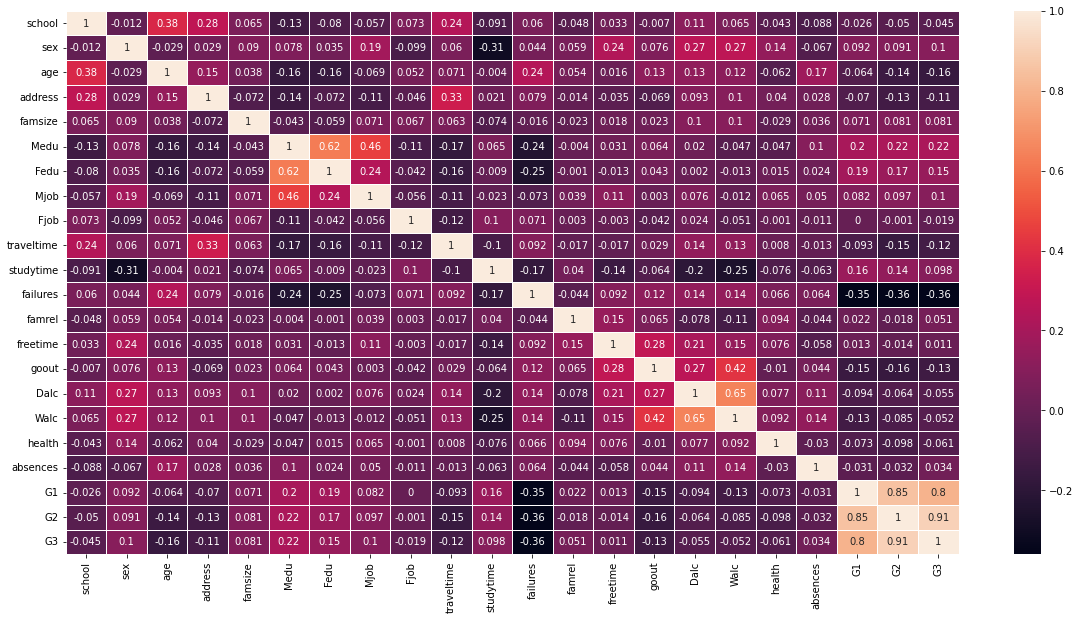

In [31]:
corr = grade.corr(method = 'pearson').round(3)
plt.figure(figsize = (20,10))
sns.heatmap(data = corr, annot = True, linewidth = .5) #sex age Medu Fedu Mjob Fjob failures goout

## Entraînement
### Préparation
#### Variable d'intérêt

In [32]:
X = pd.DataFrame(np.c_[grade['sex'], grade['age'], grade['Medu'], grade['Fedu'], grade['Mjob'], grade['Fjob'], grade['failures'], grade['goout']], 
                 columns = ['sex', 'age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'failures', 'goout'])
y = grade['G3']

### Division du jeu de données
#### Effectifs

In [33]:
n_train = round(len(grade) * 0.6)
n_test = round(len(grade) * 0.2)
n_calib = len(grade) - (n_train + n_test)
print(n_train, n_test, n_calib)

237 79 79


#### Division

In [34]:
X_train = X[0:n_train]
y_train = y[0:n_train]
X_calib = X[n_train:(n_train + n_test)]
y_calib = y[n_train:(n_train + n_test)]
X_test = X[(n_train + n_test):]
y_test = y[(n_train + n_test):]

### Modèle
#### Création du modèle

In [35]:
#nc = NcFactory.create_nc(KNeighborsRegressor(n_neighbors=11)) # accuracy 0.91
nc = NcFactory.create_nc(RandomForestRegressor(n_estimators=500)) # accuracy 0.97
#nc = NcFactory.create_nc(DecisionTreeRegressor(min_samples_leaf=5)) # accuracy 0.94
icp = IcpRegressor(nc)

#### Entraînement

In [36]:
icp.fit(X_train, y_train)

#### Calibration

In [37]:
icp.calibrate(X_calib, y_calib)

## Prédiction
### Prédiction des valeurs

In [ ]:
y_pred = icp.predict(X_test.values, significance = 0.05)

#### Niveau de précision

In [39]:
suc = 0
for i in range(n_test):
    if (y_test[(n_train + n_test + i)] > y_pred[i,0]) and (y_test[(n_train + n_test + i)] < y_pred[i,1]):
      suc += 1
acc = suc / n_test
("Précision du modèle :", acc)

('Précision du modèle :', 0.9620253164556962)